# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strengths
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [9]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **comp411/classifiers/softmax.py**. 


In [11]:
# First implement the naive softmax loss function with nested loops.
# Open the file comp411/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from comp411.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.341204
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ 
 
Since weights are randomly initialized, first set of scores are random. Then, expectation of score of each class is the same. So, $e^{S_{y_i}}$ / $\sum_{j} e^j$ should roughly be equal to 1/10. By the law of large numbers, it will converge to 1/10 as we calculate over larger datasets rather than single points.

In [12]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from comp411.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularizations
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.757163 analytic: -1.757163, relative error: 3.428068e-08
numerical: 0.408018 analytic: 0.408018, relative error: 1.381054e-08
numerical: 1.186677 analytic: 1.186677, relative error: 8.504385e-09
numerical: -1.531649 analytic: -1.531649, relative error: 2.754057e-09
numerical: 1.189149 analytic: 1.189149, relative error: 4.763382e-09
numerical: 1.256904 analytic: 1.256904, relative error: 3.220467e-09
numerical: 3.145621 analytic: 3.145621, relative error: 1.432623e-08
numerical: -3.553480 analytic: -3.553480, relative error: 2.673638e-09
numerical: 0.616458 analytic: 0.616458, relative error: 6.326802e-09
numerical: 1.302168 analytic: 1.302168, relative error: 6.725107e-10
numerical: 51.097977 analytic: 51.097977, relative error: 2.070581e-10
numerical: -49.793552 analytic: -49.793552, relative error: 4.174786e-10
numerical: -51.295974 analytic: -51.295974, relative error: 4.501136e-11
numerical: -46.999787 analytic: -46.999788, relative error: 1.195123e-09
numerical: -47

In [13]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.341216e+00 computed in 0.190063s
vectorized loss: 2.341216e+00 computed in 0.029138s
Loss difference: 0.000000
Gradient difference: 0.000000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from comp411.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be similar to the validation that you did for the SVM; save      #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7]
regularization_strengths_l2 = [0, 0.1, 10, 2.5e4, 5e4]
regularization_strengths_l1 = [0, 0.1, 10, 2.5e2, 5e2]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rg_l1 in regularization_strengths_l1:
        for rg_l2 in regularization_strengths_l2:
            model = Softmax()
            loss_hist = model.train(X_train, y_train, learning_rate=lr, reg=rg_l2, reg_l1=rg_l1, num_iters=1500, verbose=True)

            y_train_pred = model.predict(X_train)
            train_accuracy = np.mean(y_train == y_train_pred)

            y_val_pred = model.predict(X_val)
            val_accuracy = np.mean(y_val == y_val_pred)
            results[(lr, rg_l2, rg_l1)] = [train_accuracy, val_accuracy]
            
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_softmax = model
            

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, rg_l2, rg_l1 in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rg_l2,rg_l1)]
    print('lr %e rg_l2 %e rg_l1 %e train accuracy: %f val accuracy: %f' % (
                lr, rg_l2, rg_l1, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 rg_l2 0.000000e+00 rg_l1 0.000000e+00 train accuracy: 0.250571 val accuracy: 0.259000
lr 1.000000e-07 rg_l2 0.000000e+00 rg_l1 1.000000e-01 train accuracy: 0.243898 val accuracy: 0.242000
lr 1.000000e-07 rg_l2 0.000000e+00 rg_l1 1.000000e+01 train accuracy: 0.239163 val accuracy: 0.225000
lr 1.000000e-07 rg_l2 0.000000e+00 rg_l1 2.500000e+02 train accuracy: 0.106265 val accuracy: 0.113000
lr 1.000000e-07 rg_l2 0.000000e+00 rg_l1 5.000000e+02 train accuracy: 0.132571 val accuracy: 0.123000
lr 1.000000e-07 rg_l2 1.000000e-01 rg_l1 0.000000e+00 train accuracy: 0.253061 val accuracy: 0.247000
lr 1.000000e-07 rg_l2 1.000000e-01 rg_l1 1.000000e-01 train accuracy: 0.247184 val accuracy: 0.241000
lr 1.000000e-07 rg_l2 1.000000e-01 rg_l1 1.000000e+01 train accuracy: 0.232531 val accuracy: 0.255000
lr 1.000000e-07 rg_l2 1.000000e-01 rg_l1 2.500000e+02 train accuracy: 0.123347 val accuracy: 0.113000
lr 1.000000e-07 rg_l2 1.000000e-01 rg_l1 5.000000e+02 train accuracy: 0.098286 val

In [15]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.344000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
True.


$\color{blue}{\textit Your Explanation:}$ SVM loss calculates loss for training samples that has higher error values than the margin. If a datapoint is well classified and difference between score of correct class and score of incorrect classes are larger than the margin, It will have zero loss. However, softmax gives loss value of zero when score of incorrect classes are -$\inf$. Even though it is possible in theory, in practice, it is not very likely because of the float number representation.


**Inline Question 3** 

Comment on the effects of unifying L1 and L2 losses while using Elastic Net Regularization Loss? Did L2 loss achieve better when used alone or not?

$\color{blue}{\textit Your Comment:}$
Best accurcy is achieved when we use both L1 and L2 regularization (Elastic Net Regularization). However, even though L1 regularization contributes possitively to training, L2 regularization achieves close results compared to Elastic Net Regularization.


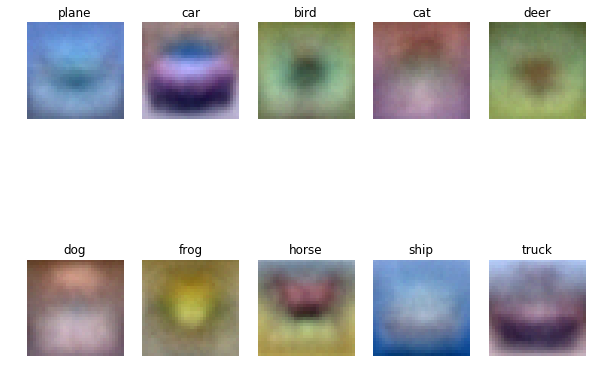

In [16]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])